# Compute S

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=10, processes=10, walltime='04:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.53:47531/status,
Dashboard: http://10.148.1.53:47531/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.53:43910,Workers: 0
Dashboard: http://10.148.1.53:47531/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
DL =100*1e3 #meters
DT = 3*3600 #seconds

In [4]:
def global_ms_drifter_sat_year(dsms):
    ds = (((dsms*dsms.nb_coloc).sum('drifter_sat_year'))/(dsms.nb_coloc.sum('drifter_sat_year'))).drop('nb_coloc')
    for v in dsms.keys():
        if v != 'nb_coloc':
            ds[v].attrs=dsms[v].attrs
    return ds

In [5]:
def plot_closure_bar(ds, id_, ax, title=1):
    """ Plot closure bars for a combination on the axis ax.
    
    Parameters
    ----------
    ds : dataset with rms of x, excx and sum (created by )
    id_: identification of the combination
    ax : axis on which to plot

    """
    dic = ds['sum_'+id_].attrs
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']

    # ACC X
    ax.bar(1.5, (np.sqrt(ds[acc]) + np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, (np.sqrt(ds[acc]) - np.sqrt(ds['exc_acc_' + id_]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(1.5, ds['exc_acc_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(1.5, ds[acc], bottom = ds['exc_acc_' + id_],
           color = 'red', width = 0.4, zorder=3, align = 'center')

    # CORIOLIS
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) + np.sqrt(ds[cor]))**2,
           color='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2, (np.sqrt(ds['exc_coriolis_' + id_]) - np.sqrt(ds[cor]))**2,
           color='w', width = 0.45, zorder=3, align = 'center', )
    ax.bar(2, ds['exc_coriolis_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2, ds[cor], bottom = ds['exc_coriolis_' + id_],
           color = 'green', width = 0.4, zorder=3, align = 'center')

    # G GRADIENT SLA
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) + np.sqrt(ds[ggrad]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, (np.sqrt(ds['exc_ggrad_' + id_]) - np.sqrt(ds[ggrad]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(2.5, ds['exc_ggrad_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(2.5, ds[ggrad], bottom = ds['exc_ggrad_' + id_],
           color = 'c', width = 0.4, zorder=3, align = 'center')

    # WIND
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) + np.sqrt(ds[wd]))**2,
           color ='lightgrey', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, (np.sqrt(ds['exc_wind_' + id_]) - np.sqrt(ds[wd]))**2,
           color ='w', width = 0.45, zorder=3, align = 'center',)
    ax.bar(3, ds['exc_wind_' + id_],
           color = 'lightsteelblue', width = 0.4, zorder=3, align = 'center')
    ax.bar(3, ds[wd], bottom = ds['exc_wind_' + id_],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    
    #SUM of rms^2
    ax.bar(1,ds[acc],
           color = 'red', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[cor], bottom = ds[acc],
           color = 'green', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[ggrad], bottom = ds[acc]+ds[cor],
           color = 'c', width = 0.4, zorder=3, align = 'center')
    ax.bar(1, ds[wd], bottom = ds[acc]+ds[cor]+ds[ggrad],
           color = 'mediumvioletred', width = 0.4, zorder=3, align = 'center')
    Ss=ds[acc]+ds[cor]+ds[ggrad]+ds[wd]
    ax.text(0.75, Ss+Ss/30, str(np.format_float_scientific(Ss.values,precision = 3)))

    ax.set_ylabel(r'Mean square $\langle ...^2 \rangle$ [$m^2/s^4$]')
    if isinstance(title, int): ax.set_title(id_)
    else : ax.set_title(title+'\n'+id_+'\n')
    
    #TOTAL
    S = ds['sum_'+id_]
    ax.bar(0.5, S, color ='k',width = 0.4, zorder=3)
    ax.text(0.25, S+S/20, str(np.format_float_scientific(S.values,precision = 3)))
    ax.axhline(y=S, c="k", linewidth=2, ls=':', zorder=4)
    
    #ax.set_ylim((0,8e-5))
    ax.grid(axis='y', zorder=0)
    
    N=np.arange(0.5,3.5, 0.5) 
    #g = ds[ggrad].attrs['long_name'].replace('rms[',r'').replace(']','').replace('altimatchup','aviso').replace('driftermatchup','aviso').split('+')
    #ggrad_tick='$\n $+'.join(g)
    #w = ds_all['rms_es_cstrio_z15_alti_wd_x'].attrs['long_name'].replace('rms[',r'').replace(']','').split(' from')
    #wd_tick = '\n from'.join(w)
    #ticks = (r'$\langle S^2\rangle$',r'$\sum_x \langle x^2\rangle$',r'$d_tu$', r'$-fv$', ggrad_tick, r'$\frac{1}{\rho}\partial_z\tau_x$')
    #ax.set_xticks(N, ticks,)

    print(f'acc:{ds[acc].values}, coriolis:{ds[cor].values}, ggrad:{ds[ggrad].values}, wind:{ds[wd].values}')

_____
# All

In [6]:
ds = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}.zarr')).persist()
ds['drifter_sat_year'] = labels
ds_ = global_ms_drifter_sat_year(ds)
#dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok','ms_drogued.zarr')).persist()
#dsnd = xr.open_dataset(os.path.join(zarr_dir+'_ok','ms_undrogued.zarr')).persist()

acc:2.0769604596864347e-10, coriolis:4.6302650737158895e-10, ggrad:1.694461440146954e-10, wind:1.5555951449092082e-11


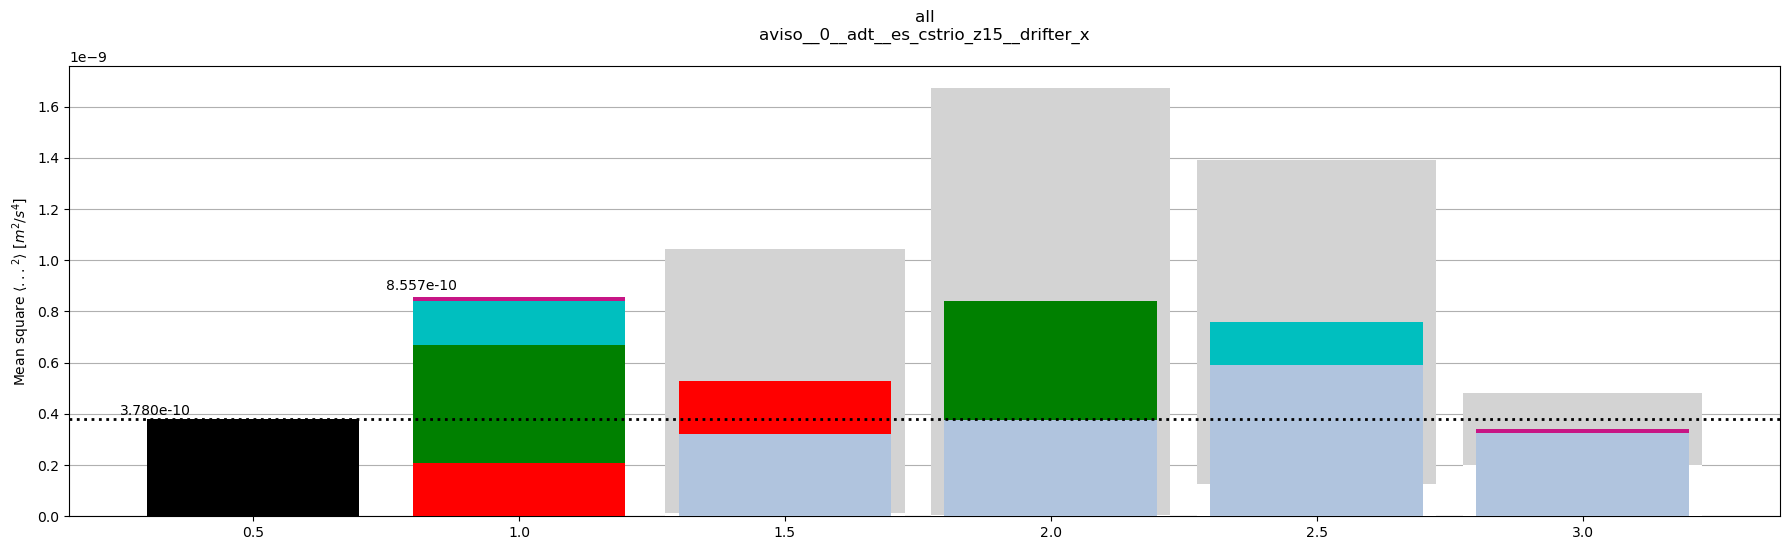

In [7]:
id_='aviso__0__adt__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

acc:2.0769604596864347e-10, coriolis:4.6302650737158895e-10, ggrad:2.655725471594855e-10, wind:1.5555951449092082e-11


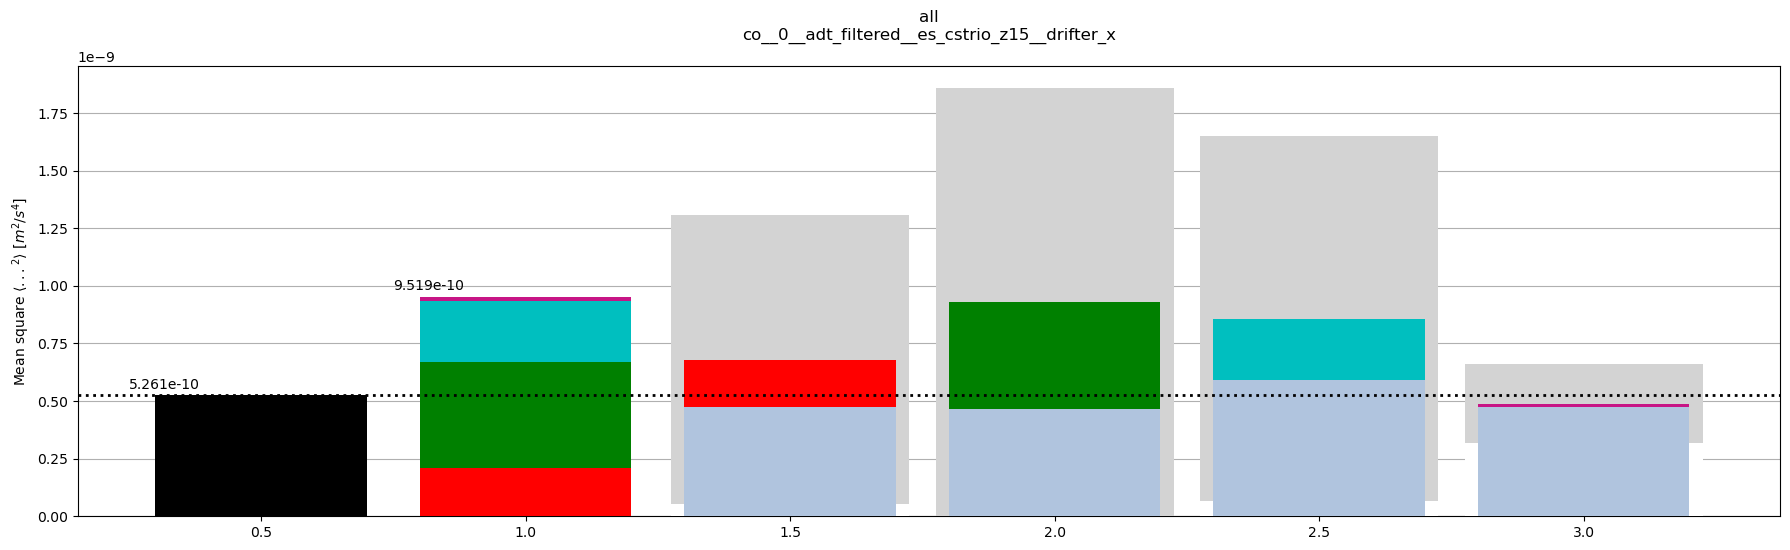

In [8]:
id_='co__0__adt_filtered__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# All gps

In [9]:
gps = [l for l in labels if 'gps' in l]
ds_gps = global_ms_drifter_sat_year(ds.sel(drifter_sat_year=gps))
#dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok','ms_drogued.zarr')).persist()
#dsnd = xr.open_dataset(os.path.join(zarr_dir+'_ok','ms_undrogued.zarr')).persist()

acc:1.5164207077627418e-10, coriolis:4.4928348592421524e-10, ggrad:1.7162477942888237e-10, wind:1.7924664508465142e-11


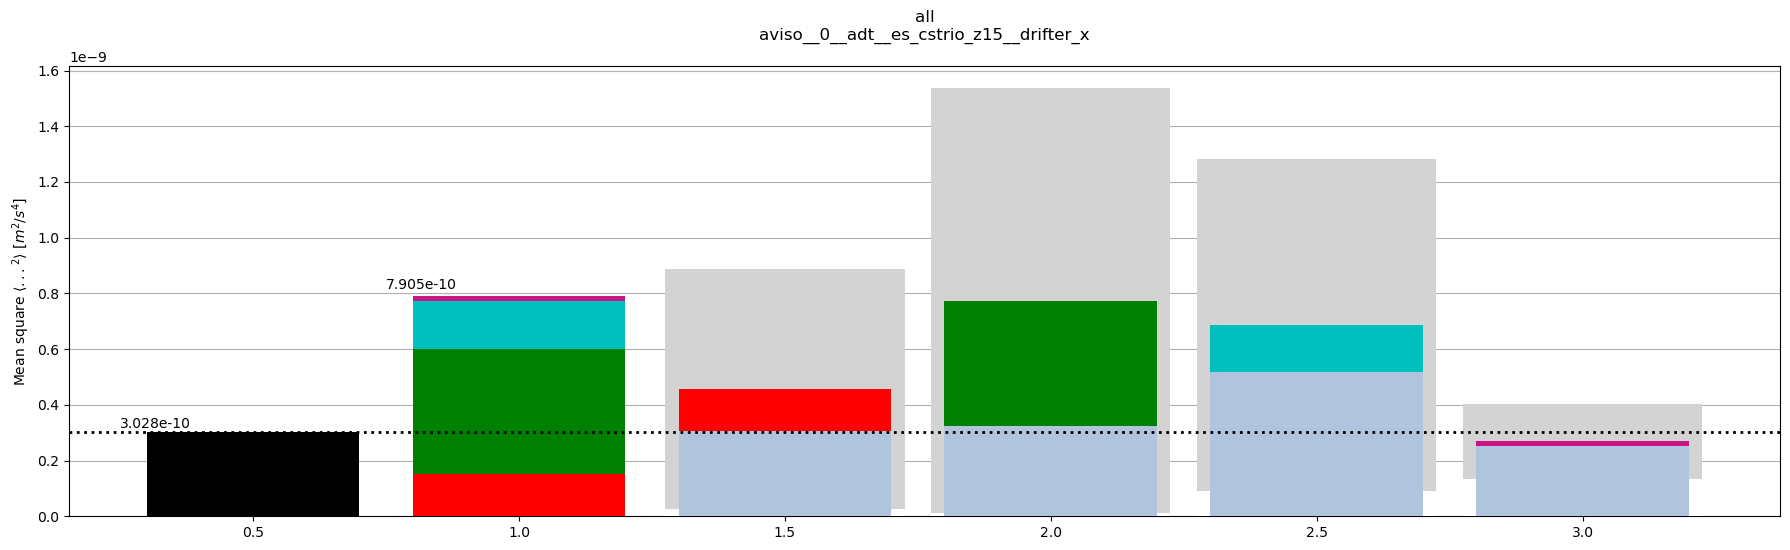

In [10]:
id_='aviso__0__adt__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_gps, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

acc:1.5164207077627418e-10, coriolis:4.4928348592421524e-10, ggrad:2.669494744175665e-10, wind:1.7924664508465142e-11


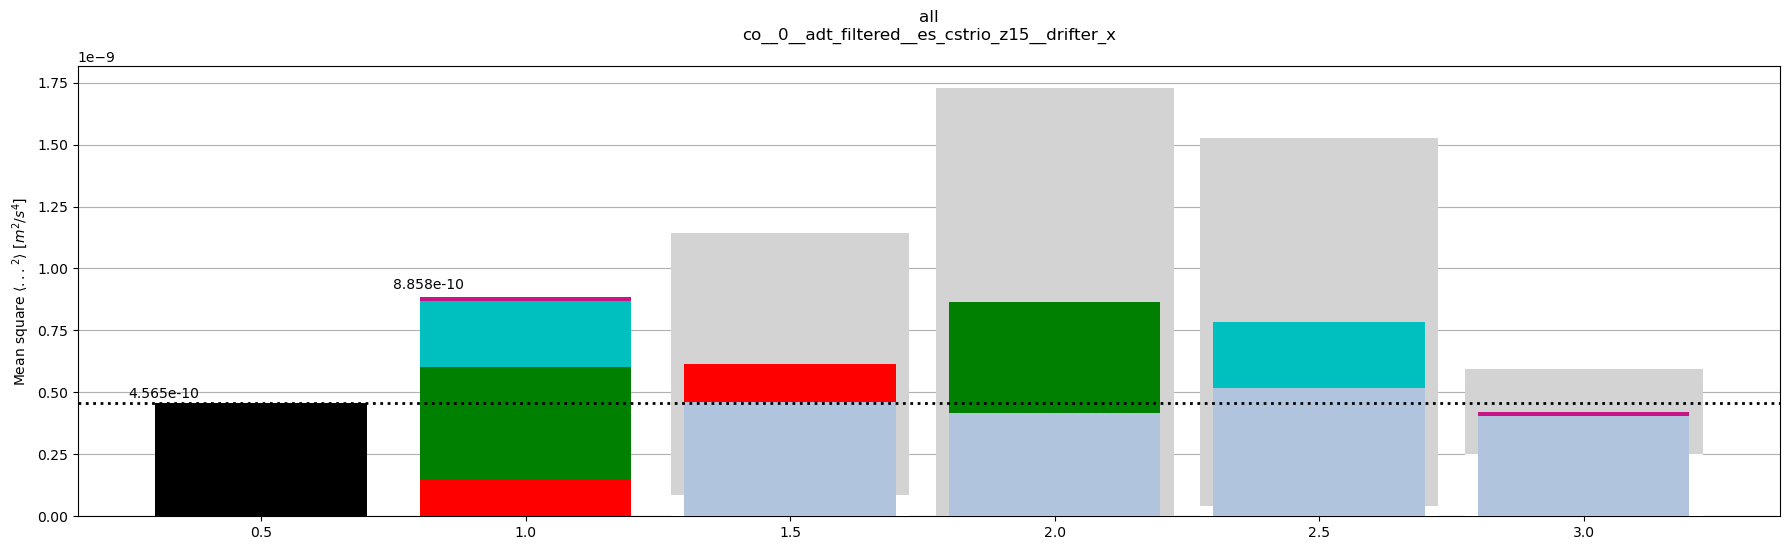

In [11]:
id_='co__0__adt_filtered__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(ds_gps, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# All drogued

In [12]:
dsd = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'ms_{DL//1000}_{DT}_drogued.zarr')).persist()
dsd_ = global_ms_drifter_sat_year(dsd)

acc:1.8488600014677287e-10, coriolis:3.868522733285593e-10, ggrad:1.8693928962615145e-10, wind:1.6407336377879063e-11


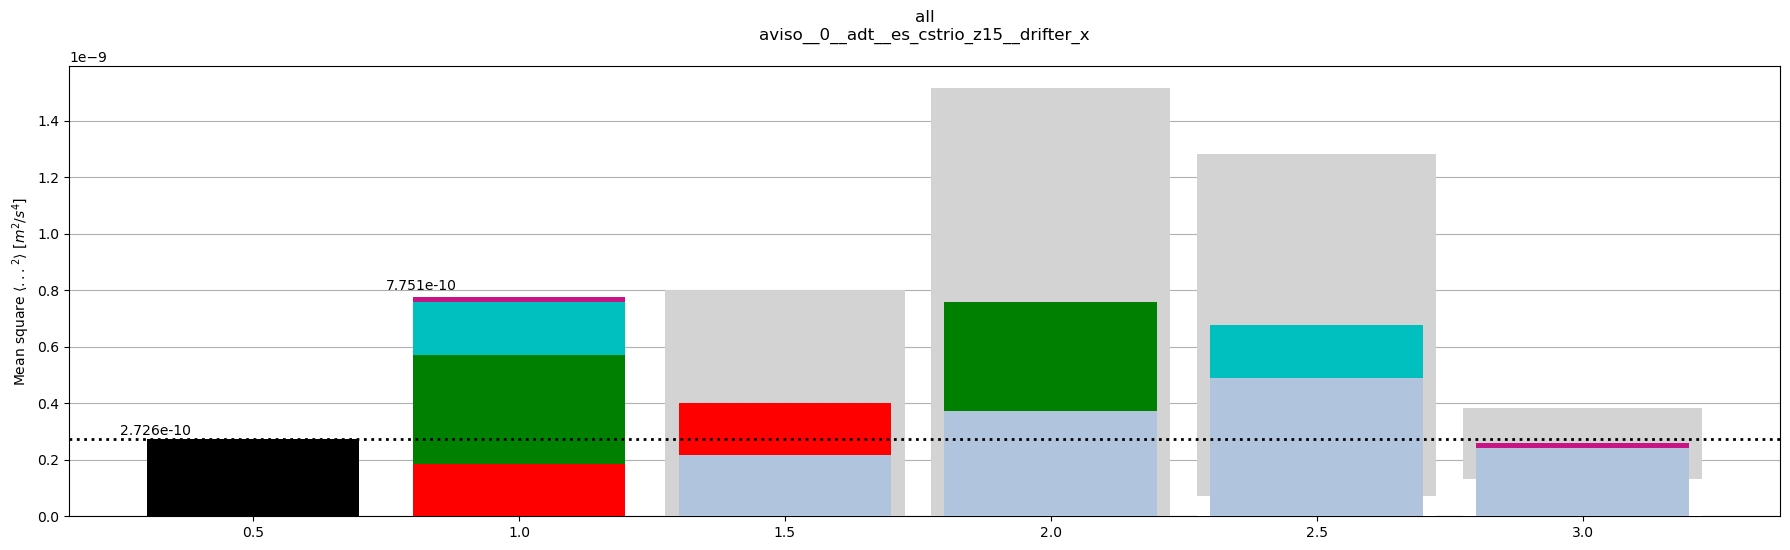

In [13]:
id_='aviso__0__adt__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(dsd_, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

acc:1.8488600014677287e-10, coriolis:3.868522733285593e-10, ggrad:2.891747327684424e-10, wind:1.6407336377879063e-11


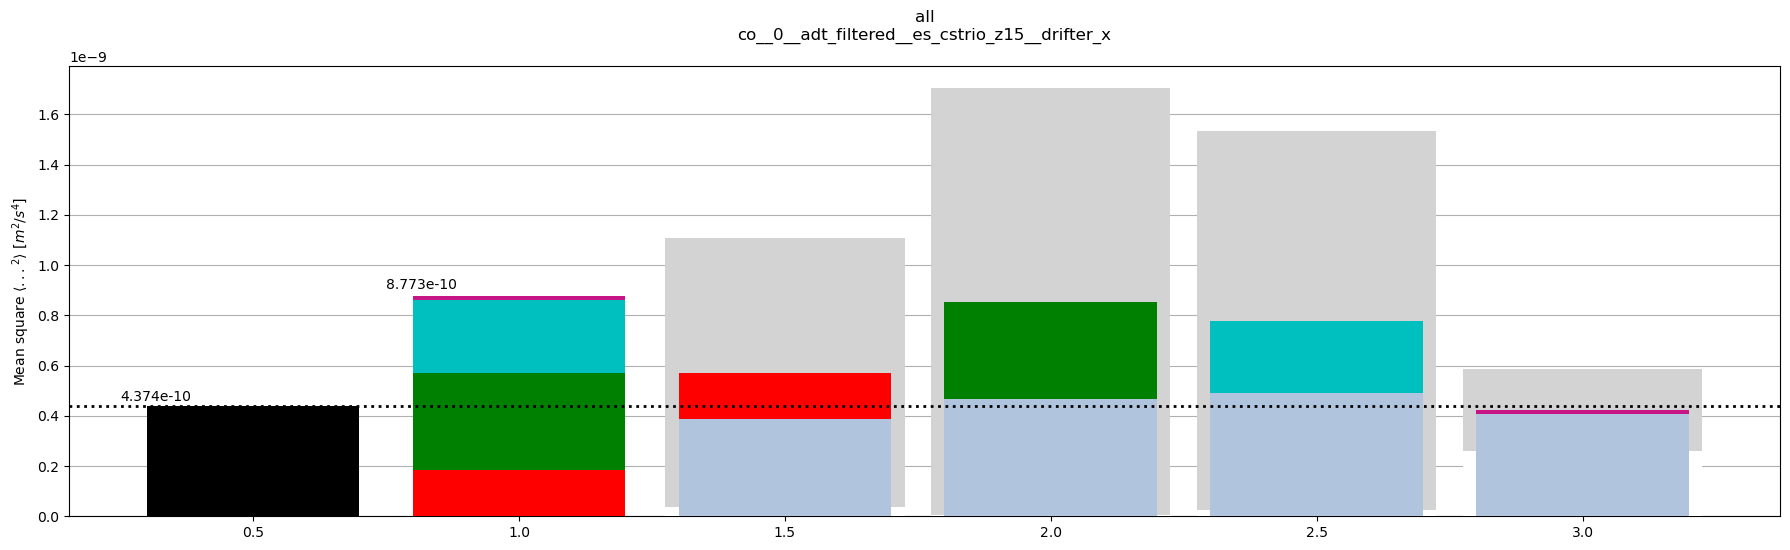

In [14]:
id_='co__0__adt_filtered__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(dsd_, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

_____
# Drogued &gps

In [20]:
gps = [l for l in dsd.drifter_sat_year.values if 'gps' in l]
dsd_gps = global_ms_drifter_sat_year(dsd.sel(drifter_sat_year=gps))


acc:1.4146065069516568e-10, coriolis:3.730268315019987e-10, ggrad:1.8011328969622654e-10, wind:1.8053452017610314e-11


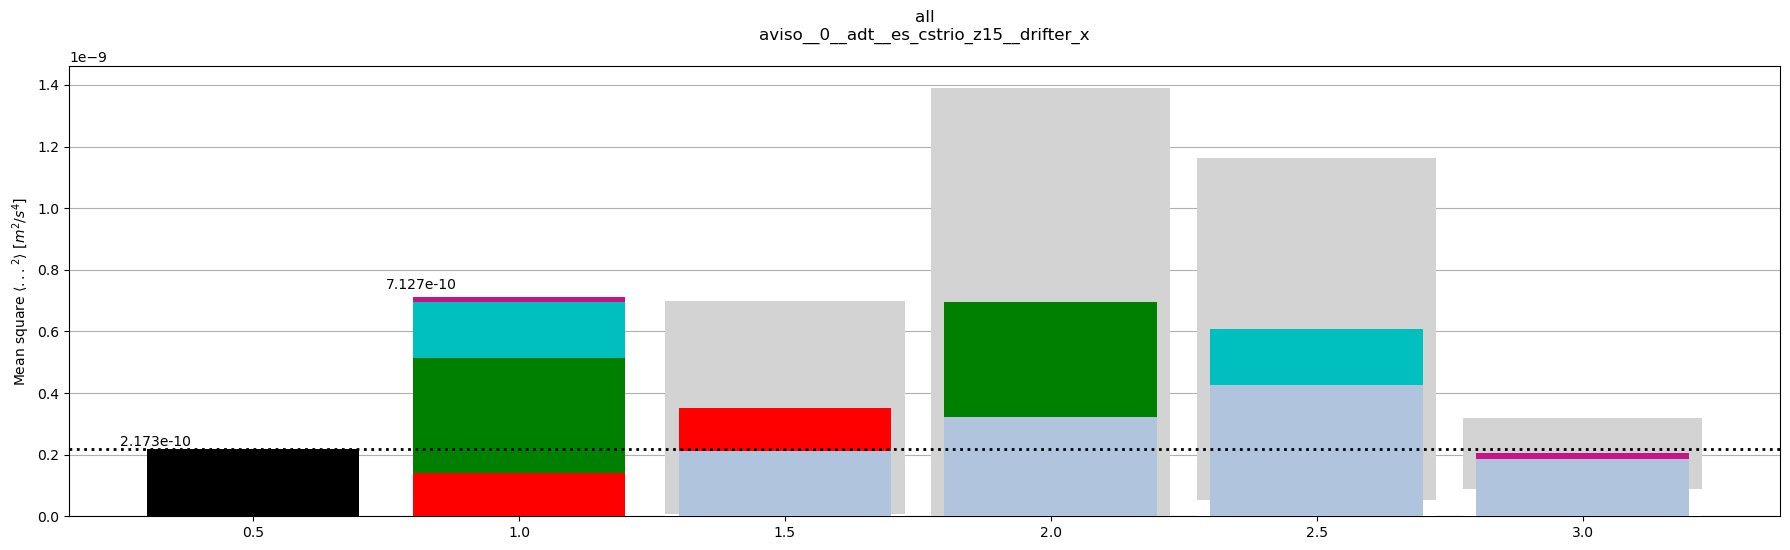

In [22]:
id_='aviso__0__adt__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(dsd_gps, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

acc:1.4146065069516568e-10, coriolis:3.730268315019987e-10, ggrad:2.7947198645710157e-10, wind:1.8053452017610314e-11


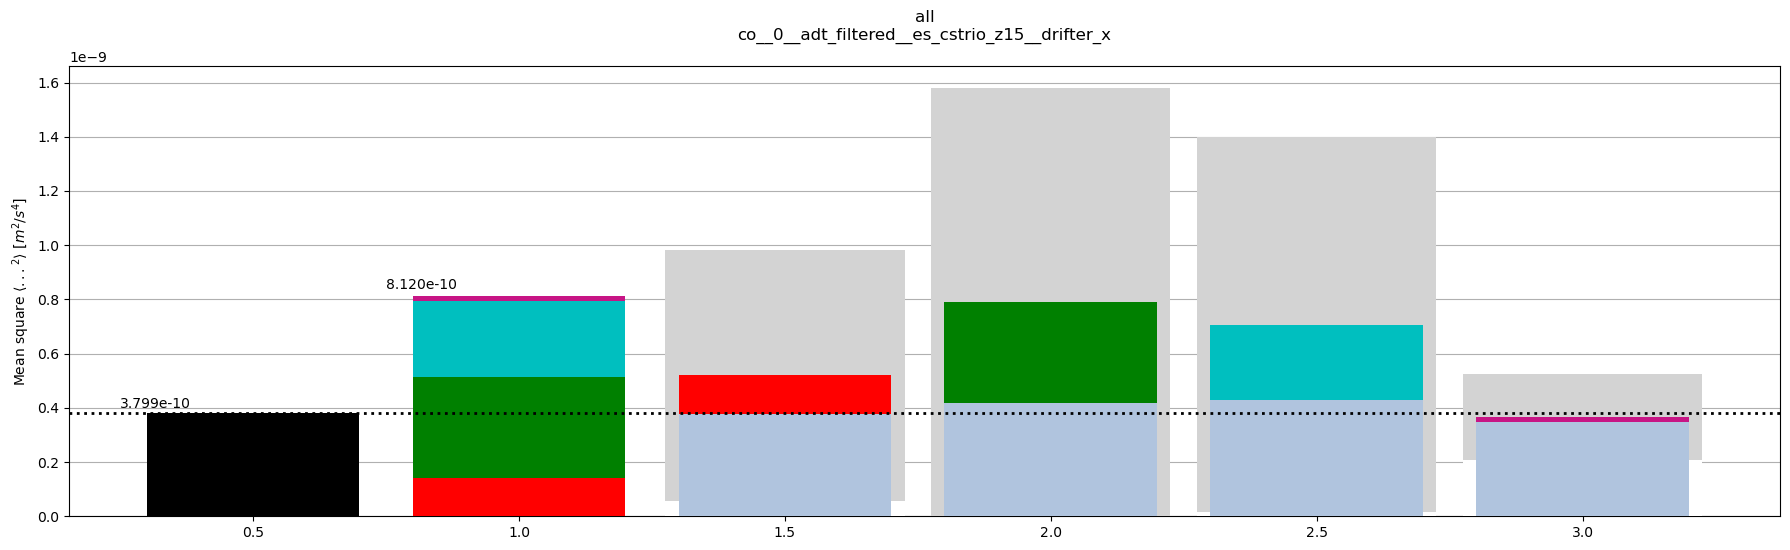

In [23]:
id_='co__0__adt_filtered__es_cstrio_z15__drifter_x'
#fig_title='All altimeters vs SARAL vs Sentinel3A'
fig_title=1
fig, axs = plt.subplots(nrows=1,ncols=1,
                            sharey='all',
                            figsize=(18,7))
plot_closure_bar(dsd_gps, id_,axs, title = 'all')

if isinstance(fig_title, str):
    fig.suptitle(fig_title,)


colors=['k', 'lightsteelblue','lightgrey', 'red', 'green', 'c','mediumvioletred']
labels_ = [r'$\langle S^2\rangle$',
           r'$\langle S_{-x}^2\rangle$',
           r'$[(\sqrt{\langle S_{-x}^2\rangle}-\sqrt{\langle x^2\rangle})^2,(\sqrt{\langle S_{-x}^2\rangle}+\sqrt{\langle x^2\rangle})^2$]',
           r'$\langle (x=d_tu)^2\rangle $ from drifters',
          r'$\langle (x=-fv)^2\rangle$ from drifters',
          r"$\langle (x=g\partial_x\eta)^2\rangle$",
           r"$\langle (x=\frac{1}{\rho}\partial_z\tau_x)^2\rangle$",
          ]                                                                                                                                                              

#handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(labels_))]
#fig.legend(handles, labels_, ncol=3,loc='lower center')#, bbox_to_anchor=(1,         0.5))#bbox_transform=fig.transFigure,
fig.tight_layout(rect=[0,0.2,1,1])#left, bottom, right, top (default is 0,0,1,1)

In [18]:
cluster.close()

KeyboardInterrupt: 